In [61]:
# load env
from dotenv import load_dotenv
import os
load_dotenv()

os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["PINECODE_API_KEY"]=os.getenv("PINECODE_API_KEY")
os.environ["GOOGLE_API_KEY"]=os.getenv("GOOGLE_API_KEY")
os.environ["HUGGINGFACE_API_KEY"]=os.getenv("HUGGINGFACE_API_KEY")
os.environ["LANGCHAIN_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"]=os.getenv("LANGCHAIN_PROJECT")
os.environ["LANGCHAIN_TRACING_V2"]=os.getenv("LANGCHAIN_TRACING_V2")
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")

In [62]:
# pydantic model
from pydantic import BaseModel,Field

class TopicSelector(BaseModel):
    topic:str=Field(description="topic name")
    reason_for_selection:str=Field(description="topic selection reason")        



In [63]:
# llm model using reasoning model of google
from langchain_google_genai import ChatGoogleGenerativeAI

model = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2
)

In [64]:
# using hugging face embeddings
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
vector_dimension=len(embeddings.embed_query("hi"))
vector_dimension

768

In [65]:
from langchain_community.document_loaders import DirectoryLoader, TextLoader
# load document pages
loader=DirectoryLoader("./data",glob="./*.txt",loader_cls=TextLoader,show_progress=True)
pages = loader.load()
len(pages)

# split pages to chunks
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=50
)

chunks=text_splitter.split_documents(pages);

len(chunks)


100%|██████████| 1/1 [00:00<00:00, 2202.89it/s]


55

In [66]:
# using chromdb as vector store
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
# initialized the vector db
vector_store = Chroma(
    collection_name="usa-gdp-data",
    embedding_function=embeddings
)

In [67]:
# save documents to vector db
vector_store.add_documents(chunks)

['7c9fb2d6-4581-4c11-bc00-d22b282b2279',
 '3a39f006-e0b6-410b-844f-9642b732d4dc',
 '0bf312cb-38b7-4445-998f-da606966f510',
 'b990ae85-84f5-4fd3-895b-b5b5f05692c3',
 'e7c2fb2b-8d43-442d-b435-bf94a7bc14bb',
 'b027afee-6761-4b4e-a44b-f1cc11655222',
 '2b29afdb-13d9-4aa0-9190-cb3bd94aa885',
 '4cf8cc18-0705-4855-bf8f-73bdecd45c24',
 '7745d148-4306-4d6c-919d-b98973136c40',
 'cbb0ebbc-4b43-4e71-b3cc-e79cb3a39e71',
 'd5eebf9d-0445-4957-810a-34d0ecb1f324',
 'df79f477-7504-401d-a7bf-3e5db5d6c507',
 'd0a712de-a1c4-4081-b7d2-1f98208bad60',
 'd1321500-3741-41ee-92e0-353cba57eea0',
 '4f6688f3-ea05-4fe8-a3b1-2d057c49f786',
 '6b11ce2c-5d7f-4d27-a6a3-e51e3642d85c',
 '27daf49a-87b5-48c5-acea-3fde23e4d69a',
 'cfe5a340-1433-4628-802d-4d26fb8f9409',
 'fb76ddc9-a7c7-4ec4-8b27-efb6b1999146',
 '453feab1-5420-4246-96f0-f79b589b0c82',
 'e177818a-ac85-482f-902e-be7c47a113ce',
 '6cb86d55-fc99-4a85-bc7f-22f86dadb36d',
 '733e83b5-933b-4388-a190-26c08e4ebf41',
 '882e61db-f4d8-41f4-bc13-c375ea2041b6',
 '2d674695-0ede-

In [68]:
# chromadb as retriever
data_retriever=vector_store.as_retriever(search_kwargs={"k":3})
data_retriever.invoke("industrial growth of usa?")

[Document(id='002355cc-8607-4f31-bb38-cbb981737acd', metadata={'source': 'data/usa.txt'}, page_content='🇺🇸 Overview of the U.S. Economy'),
 Document(id='7c9fb2d6-4581-4c11-bc00-d22b282b2279', metadata={'source': 'data/usa.txt'}, page_content='🇺🇸 Overview of the U.S. Economy'),
 Document(id='d1cb0c78-fcb0-45bd-8657-198bf8ee60ad', metadata={'source': 'data/usa.txt'}, page_content='The U.S. maintains its GDP growth through strong innovation, entrepreneurship, and investment in R&D. With companies like Apple, Google, Amazon, Microsoft, and Tesla leading global markets, the U.S.')]

In [69]:
# create custom state for langgraph
import operator
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
class AgentState(TypedDict):
    messages:Annotated[Sequence[BaseMessage],operator.add]

In [70]:
# supervisor 
from langchain_core.output_parsers import StrOutputParser
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import PromptTemplate
supervisor_parser=PydanticOutputParser(pydantic_object=TopicSelector)
def supervisor(state:AgentState):
    print("## supervisor ##")
    question=state["messages"][-1]
    print(f"## supervisor ## question : {question}")
    template="""
    
    You are a smart classifier that categorizes questions based on their relevance to the USA and whether a language model (LLM) can answer them.

    Classify the given question into one of the following three categories:

    1. USA  - if question related to USA
    2. WEB  - if question related to latest news or current affairs
    3. LLM  - if none of the above

    Respond with ONLY the category number (USA, LLM, or WEB). Also provide reason for selecting the specific category

    User query: {question}
    {format_instructions}
    """
    
    prompt=PromptTemplate(
        template=template,
        input_variable=["question"],
        partial_variables={"format_instructions": supervisor_parser.get_format_instructions()}
    )
    
    chain=prompt|model|supervisor_parser
    
    response=chain.invoke({"question":question})
    
    print(f"## supervisor ## response : {response}")
    
    return {"messages":[response.topic]}

In [71]:
supervisor({'messages':["Tell me about the yesterday plane crash"]})

## supervisor ##
## supervisor ## question : Tell me about the yesterday plane crash
## supervisor ## response : topic='WEB' reason_for_selection='Plane crashes are current events, requiring up-to-date information from the web.'


{'messages': ['WEB']}

In [72]:
# router 
def router(state:AgentState):
    print("## router ##")
    last_message=state["messages"][-1]
    print(f"## router ## last_message : {last_message}")
    if "rag" in last_message.lower():
        return "rag call"
    elif "llm" in last_message.lower():
        return "llm call"
    else :
        return "web call"

In [73]:
from langchain_core.runnables import RunnablePassthrough
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)
# rag call
def rag_call(state:AgentState):
    print("## rag_call ##")
    question = state["messages"][0]
    print(f"## rag_call ## question : {question}")
    prompt=PromptTemplate(
        template="""You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:""",
        
        input_variables=['context', 'question']
    )
    
    rag_chain = (
        {"context": data_retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | model
        | StrOutputParser()
    )
    result = rag_chain.invoke(question)
    return  {"messages": [result]}

In [74]:
rag_call({"messages":["how are you?"]})

## rag_call ##
## rag_call ## question : how are you?


{'messages': ['I am an AI assistant and do not have feelings, so I am not capable of experiencing emotions like "being." I am functioning as expected and ready to assist you.']}

In [75]:
# web call
from langchain_community.tools.tavily_search import TavilySearchResults
def web_call(state:AgentState):
    print("## rag_call ##")
    question = state["messages"][0]
    print(f"## rag_call ## question : {question}")
    # web search tavily
    tavily_api_key=os.getenv("TAVILY_API_KEY")
    tavily_tool=TavilySearchResults(travily_api_key=tavily_api_key)
    result = tavily_tool.run(question)
    return {"messages": [result]}

In [76]:
web_call({"messages":["who is winner of 2025 IPL?"]})

## rag_call ##
## rag_call ## question : who is winner of 2025 IPL?


{'messages': [[{'title': 'IPL 2025 results: Get all cricket scores, points table, standings and ...',
    'url': 'https://www.olympics.com/en/news/ipl-2025-results-cricket-scores-standings-points-table-net-run-rate',
    'content': 'The [**IPL 2025**](https://www.olympics.com/en/news/indian-premier-league-ipl-2025-schedule-match-list) concluded on June 3 with Royal Challengers Bengaluru defeating Punjab Kings in the final to lift their maiden title.\n\nThis was the 18th edition of the [**Indian Premier League**](https://www.olympics.com/en/news/indian-premier-league-ipl-winners-list-champions) - the world’s most lucrative franchise-based T20 league.\n\nRCB became the eighth team to win the IPL trophy. [...] The top two teams - PBKS and RCB - battled it out in Qualifier 1, with the Royal Challengers winning it to earn a direct ticket to the final.\n\nHowever, PBKS ended up joining RCB in the finale after defeating MI, who defeated GT in the Eliminator.\n\nOverall, MI and CSK are the mos

In [77]:
from langchain_openai import ChatOpenAI
from langchain.tools import Tool
from langchain.agents import initialize_agent, AgentType
# llm call with tools integration
def llm_call(state:AgentState):
    print("## llm_call ##")
    question = state["messages"][0]
    print(f"## llm_call ## question : {question}")

    llm_template="Answer the follow question with you knowledge of the real world. Following is the user question: {question}" 
    prompt = PromptTemplate(
    template=llm_template,
    input_variables=["question"]
    )
    
    chain = prompt | model | StrOutputParser()
    response = chain.invoke({"question": question})
    return {"messages": [response]}

In [78]:
llm_call({"messages":["how are you ?"]})

## llm_call ##
## llm_call ## question : how are you ?


{'messages': ['As a large language model, I don\'t experience feelings or emotions like humans do. So, I can\'t be "good" or "bad" in the way a person can.\n\nHowever, I am functioning as intended and ready to assist you with your requests. Thanks for asking!']}

In [79]:
# validation or guard_rail
def guard_rail(state:AgentState):
    print("## guard_rail ##")
    last_message=state["messages"][-1]
    print(f"## guard_rail ## last_message : {last_message}")
    return {"messages":["pass"]}

from langgraph.graph import StateGraph, START, END    
# guard_router
def guard_router(state:AgentState):
    print("## guard_router ##")
    last_message=state["messages"][-1]
    print(f"## guard_router ## last_message : {last_message}")
    if "pass" in last_message.lower():
        return END
    else :
        return "supervisor"

In [83]:
# langgraph
from langgraph.graph import StateGraph, START, END

work_flow=StateGraph(AgentState)

work_flow.set_entry_point("supervisor")

work_flow.add_node("supervisor",supervisor)

work_flow.add_node("llm",llm_call)

work_flow.add_node("rag",rag_call)

work_flow.add_node("web",web_call)

work_flow.add_node("guard_rail",guard_rail)

work_flow.add_conditional_edges(
    "supervisor",
    router,
    {
        "llm call" : "llm",
        "web call" : "web",
        "rag call" : "rag",
    }
)

work_flow.add_edge("rag","guard_rail")

work_flow.add_edge("llm","guard_rail")

work_flow.add_edge("web","guard_rail")

work_flow.add_edge("guard_rail", END)

work_flow.add_conditional_edges(
    "guard_rail",
    guard_router,
    {
        "pass" : END,
        "fail" : "supervisor"
        
    }
)


In [84]:
# compile graph
app = work_flow.compile()

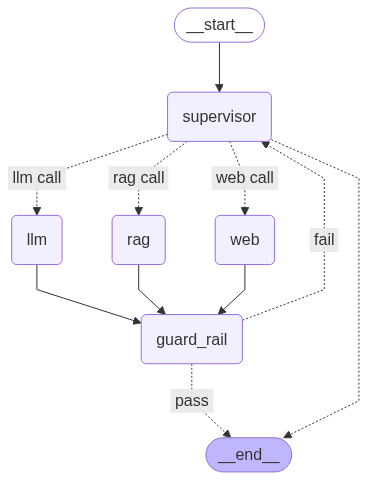

In [85]:
from IPython.display import display,Image
display(Image(app.get_graph().draw_mermaid_png()))

In [86]:
# run sample app
state={"messages":["can you tell me the industrial growth of world's most poor economy?"]}
result=app.invoke(state)
result


## supervisor ##
## supervisor ## question : can you tell me the industrial growth of world's most poor economy?
## supervisor ## response : topic='LLM' reason_for_selection='The question is about economic data, which is not specific to the USA and can be answered by a language model with access to relevant information.'
## router ##
## router ## last_message : LLM
## llm_call ##
## llm_call ## question : can you tell me the industrial growth of world's most poor economy?
## guard_rail ##
## guard_rail ## last_message : It's difficult to give a single, definitive answer to the "industrial growth of the world's most poor economy" for several reasons:

*   **Defining "Most Poor":** Poverty is complex and measured in different ways (GDP per capita, poverty rate, Human Development Index, etc.). The country at the very bottom of one list might not be at the bottom of another.
*   **Data Availability and Reliability:** The poorest economies often have the weakest statistical infrastructure. 

KeyError: '__end__'